The code from plot_generation.ipynb will be the foundation for most of this.

The main change I wanted to make was that the information for the Manhattan plot should be source from the GWAS sumstats file, and not the assoc.dat file.
In addition, we are interested in looking at all the chromosomes at one time for the Manahattan plot.
Since we already have that data we can make that change now.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import os

In [23]:
def manhattan(pop, p_threshold_significance=5e-8, subsample_cutoff=5e-1, subsample_rate=0.01):
    # Read the GWAS summary statistics file
    file_path = f'../data/raw/gwas/HF_Bothsex_{pop}_inv_var_meta_GBMI_052021_nbbkgt1.txt.gz'
    df = pd.read_csv(file_path, compression='gzip', sep='\t', header=0)

    # Ensure required columns exist
    required_cols = {'#CHR', 'POS', 'inv_var_meta_p'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing required columns in input file: {required_cols - set(df.columns)}")

    # Rename columns for consistency
    df = df.rename(columns={'#CHR': 'CHR', 'inv_var_meta_p': 'P'})

    # Select relevant columns and drop missing values
    df = df[['CHR', 'POS', 'P']].dropna()
   
    # Convert P-values to -log10(P) for plotting
    df['P'] = pd.to_numeric(df['P'], errors='coerce')
    df = df.dropna()  # Drop any remaining NaNs
    df['-log10(P)'] = df['P'].apply(lambda x: -np.log10(x))

    # Convert chromosome numbers to integers for sorting
    df['CHR'] = df['CHR'].astype(int)

    # Apply filtering:
    df_significant = df[df['P'] <= subsample_cutoff]  # Keep all SNPs below threshold
    df_nonsignificant = df[df['P'] > subsample_cutoff].sample(frac=subsample_rate, random_state=42)  # Subsample 1% of non-significant SNPs

    # Combine both datasets
    df = pd.concat([df_significant, df_nonsignificant])

    # Sort by chromosome and position
    df = df.sort_values(by=['CHR', 'POS'])

    # Generate a Manhattan plot
    plt.figure(figsize=(20, 6))
    colors = ['blue', 'red']  # Alternating colors for chromosomes

    # Create chromosome index mapping
    df['Chrom_Position'] = df.groupby('CHR')['POS'].transform(lambda x: x - x.min())

    # Set up x-axis positions
    chrom_max = df.groupby('CHR')['Chrom_Position'].max()
    chrom_offsets = chrom_max.cumsum().shift(fill_value=0)
    df['Adjusted_POS'] = df['Chrom_Position'] + df['CHR'].map(chrom_offsets)

    # Define colors
    significant_color = 'red'
    gray_shades = ['darkgray', 'lightgray']

    # Plot each chromosome separately
    for i, chrom in enumerate(df['CHR'].unique()):
        chr_data = df[df['CHR'] == chrom]
    
        # Separate significant and non-significant SNPs
        chr_significant = chr_data[chr_data['P'] <= p_threshold_significance]
        chr_nonsignificant = chr_data[chr_data['P'] > p_threshold_significance]
    
        # Plot non-significant SNPs in alternating gray shades
        plt.scatter(chr_nonsignificant['Adjusted_POS'], chr_nonsignificant['-log10(P)'],
                    color=gray_shades[i % 2], s=5, alpha=0.6)
    
        # Plot significant SNPs in red
        plt.scatter(chr_significant['Adjusted_POS'], chr_significant['-log10(P)'],
                    color=significant_color, s=10)

    # Add significance threshold line
    plt.axhline(y=-np.log10(p_threshold_significance), color='black', linestyle='dashed', linewidth=1)

    # Format x-axis to show chromosome numbers
    tick_positions = chrom_offsets + chrom_max / 2
    plt.xticks(tick_positions, [str(chrom) if chrom != 23 else 'X' for chrom in chrom_offsets.index])
    plt.ylim(0, 20)

    # Labels and title
    plt.xlabel("Chromosome")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Manhattan Plot of GWAS Data (Population: {pop})")

    plt.savefig(f'../plots/manhattan/{pop}_manhattan_v4.png')

    plt.show()

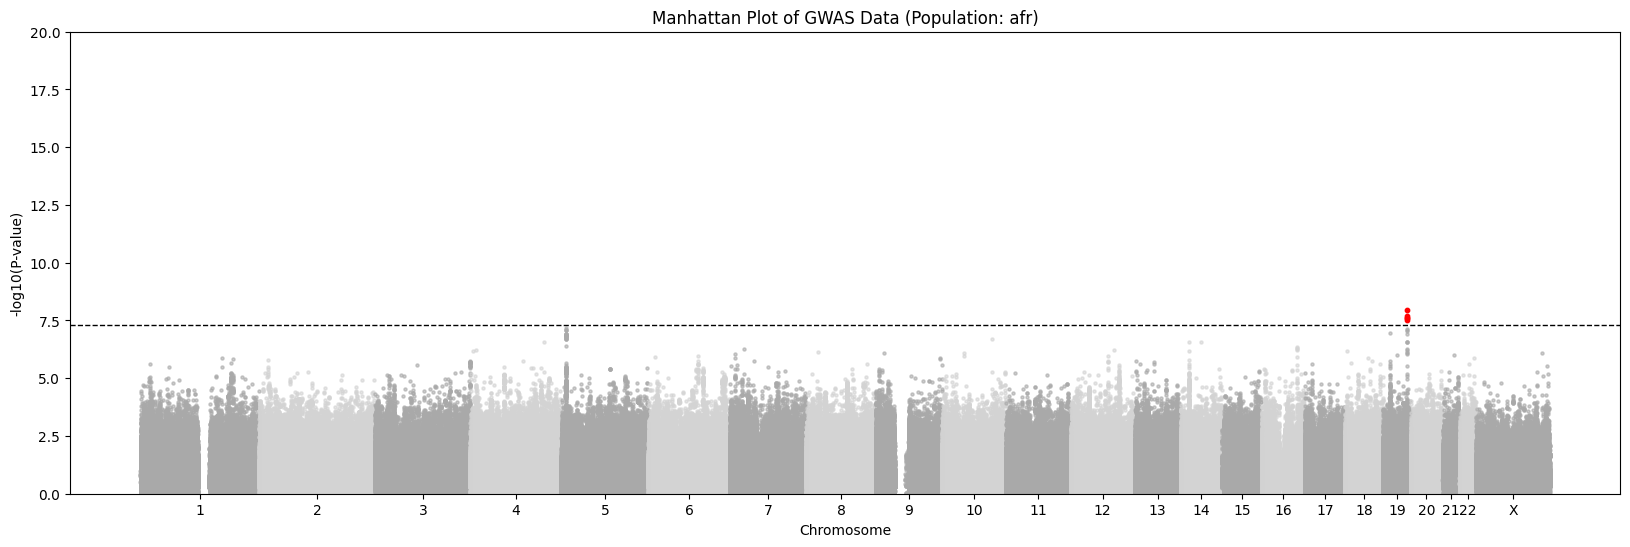

In [24]:
manhattan('afr')

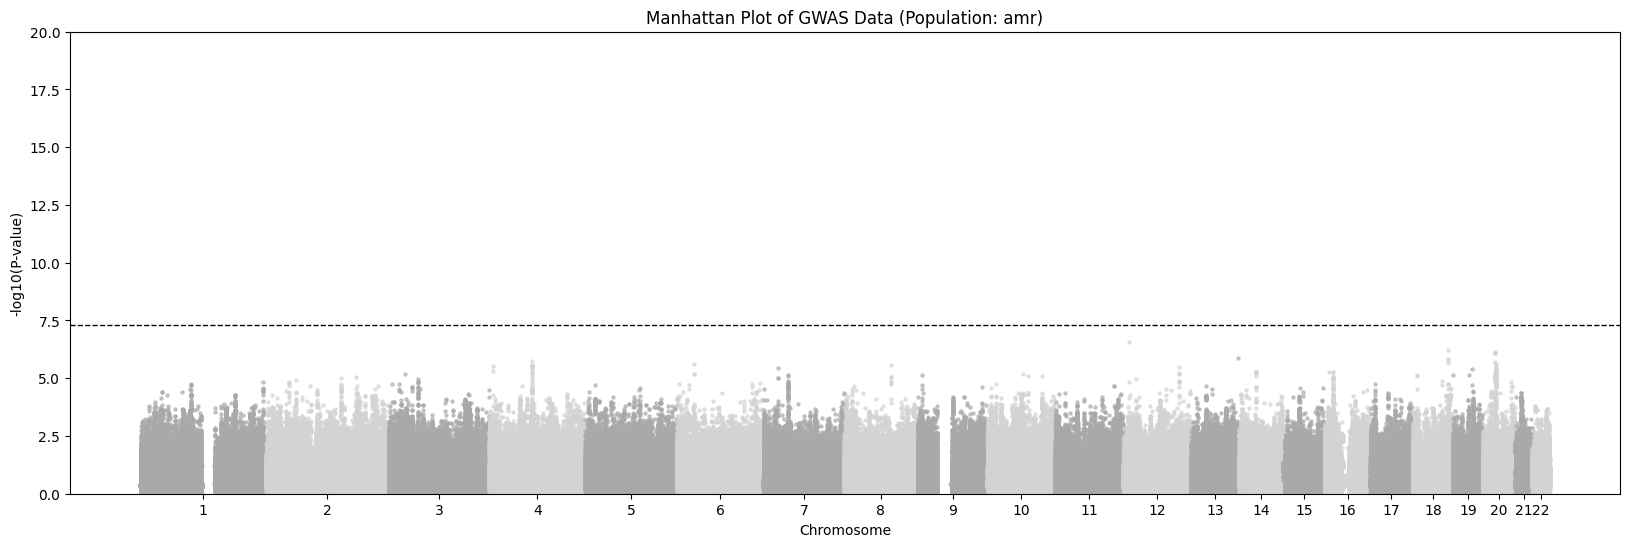

In [25]:
manhattan('amr')

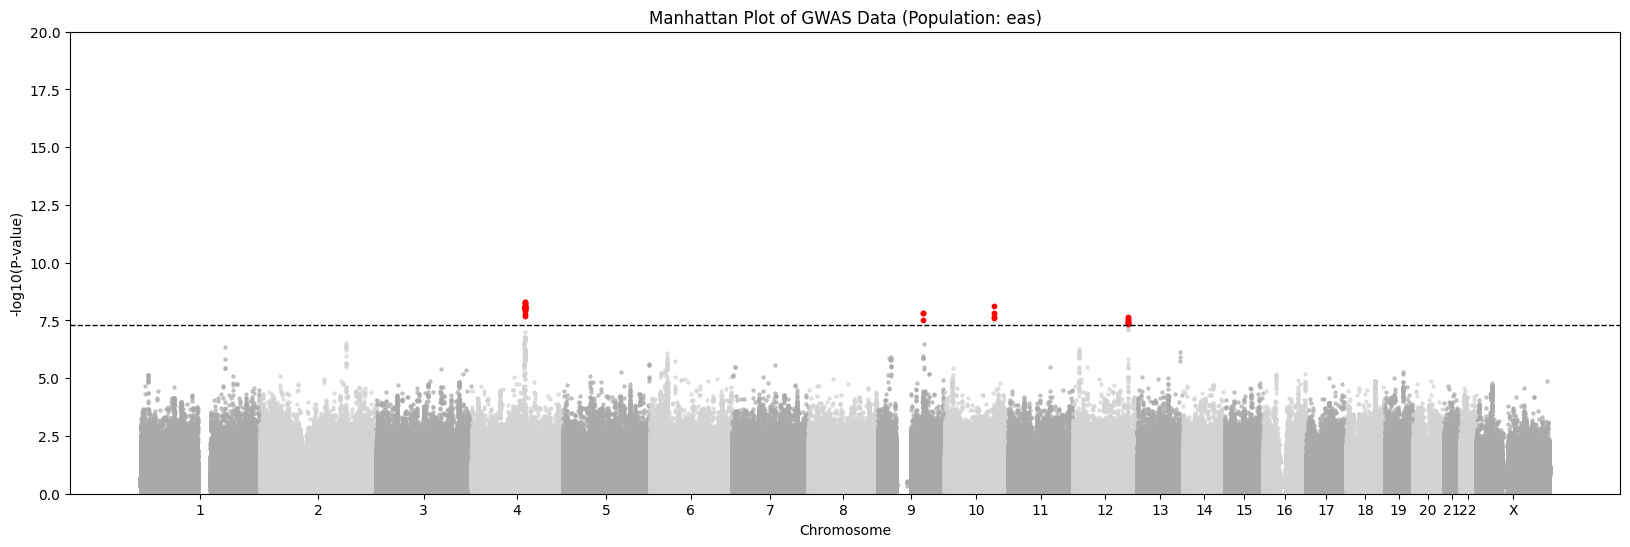

In [26]:
manhattan('eas')

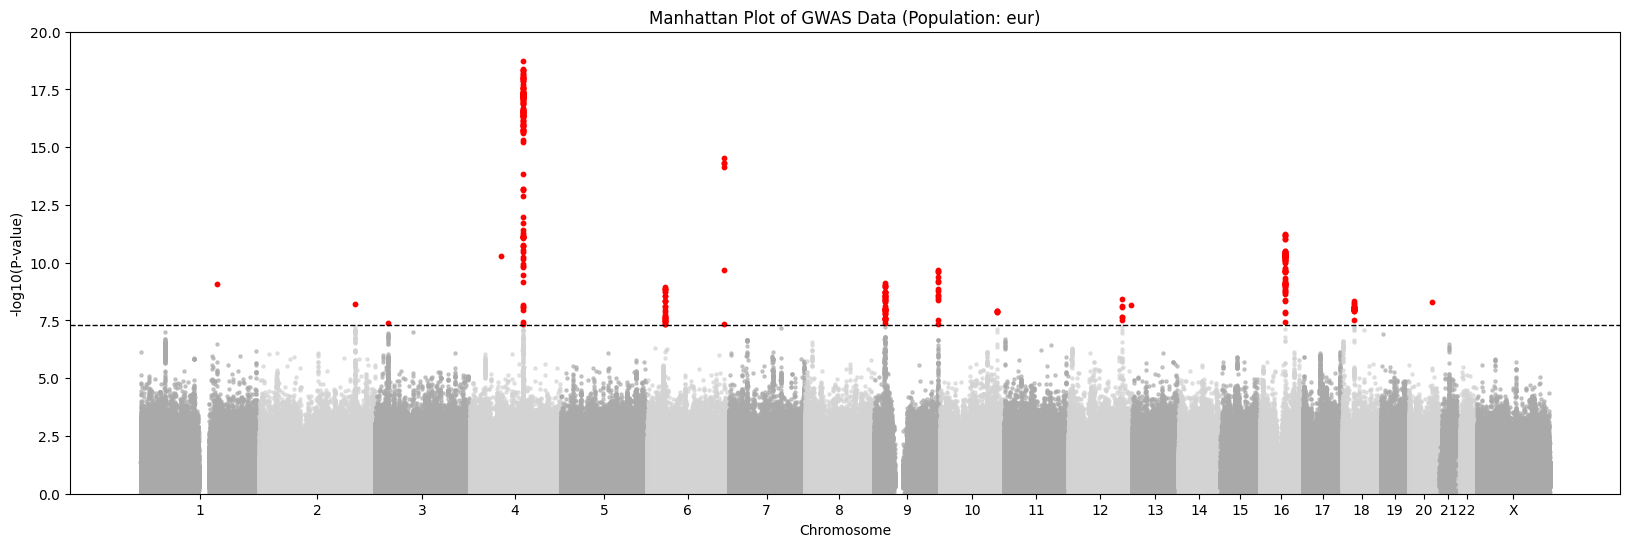

In [27]:
manhattan('eur')

## Miami Plot Prep and Creation Below

In [2]:
def data_prep(pop):
    """Reads GWAS summary statistics for all chromosomes and concatenates them."""
    all_dfs = []

    for chrom_num in range(1, 23):  # Loop through chromosomes 1-22
        file_path = f'../data/gene_associations/chr{chrom_num}.{pop}.assoc.dat'
        
        try:
            df = pd.read_csv(file_path, sep="\t")

            df = df.drop(columns=['PANEL', 'FILE'])

            # Select relevant columns
            df = df[['ID', 'CHR', 'P0', 'TWAS.P']].dropna()

            # Strip whitespace and convert to numeric, forcing errors to NaN
            df['TWAS.P'] = pd.to_numeric(df['TWAS.P'].str.strip(), errors='coerce')

            # Drop NaN values
            df = df.dropna()

            # Convert P-values to -log10(P) for plotting
            df['TWAS.P'] = df['TWAS.P'].astype(float)
            df['-log10(P)'] = df['TWAS.P'].apply(lambda x: -np.log10(x))    

            # Convert chromosome numbers to integers for sorting
            df['CHR'] = df['CHR'].astype(int)

            # Sort by chromosome and position
            df = df.sort_values(by=['CHR', 'P0'])

            all_dfs.append(df)  # Store processed df

        except FileNotFoundError:
            print(f"File not found: {file_path}, skipping chromosome {chrom_num}")

    # Concatenate all chromosome data
    final_df = pd.concat(all_dfs, ignore_index=True)

    return final_df


In [3]:
data_prep('afr')

,ID,CHR,P0,TWAS.P,-log10(P)
0,SLC35E2B,1,1661477,0.70535,0.151595
1,SLC35E2,1,1724837,0.66616,0.176421
2,TNFRSF14,1,2555638,0.78687,0.104097
3,LINC00337,1,6236239,0.81942,0.086493
4,UTS2,1,7846691,0.30728,0.512466
...,...,...,...,...,...
1470,SELO,22,50200978,0.46020,0.337053
1471,MAPK12,22,50255196,0.95380,0.020543
1472,SYCE3,22,50551111,0.51000,0.292430
1473,CHKB-AS1,22,50583025,0.23060,0.637141


In [ ]:
def miami(pop):
    """Generates a Miami plot for chromosomes 1-22 comparing given population vs 'eur'."""
    
    # Get GWAS data for both populations across all chromosomes
    df1 = data_prep('eur')
    df2 = data_prep(pop)

    # Set up the plot
    plt.figure(figsize=(14, 6))
    sig_color = 'red'  # Color for significant SNPs
    grey_colors = ['lightgrey', 'darkgrey']  # Alternating grey for non-significant SNPs

    # Track chromosome positions for spacing
    chrom_offsets = {}
    cumulative_pos = 0

    for chrom in range(1, 23):
        chr_data1 = df1[df1['CHR'] == chrom]
        chr_data2 = df2[df2['CHR'] == chrom]

        if not chr_data1.empty and not chr_data2.empty:
            min_pos = min(chr_data1['P0'].min(), chr_data2['P0'].min())
            max_pos = max(chr_data1['P0'].max(), chr_data2['P0'].max())

            chr_data1 = chr_data1.copy()
            chr_data2 = chr_data2.copy()

            chr_data1.loc[:, 'plot_pos'] = chr_data1['P0'] - min_pos + cumulative_pos
            chr_data2.loc[:, 'plot_pos'] = chr_data2['P0'] - min_pos + cumulative_pos

            chrom_offsets[chrom] = cumulative_pos + (max_pos - min_pos) / 2
            cumulative_pos += max_pos - min_pos + 1e6  # Add buffer between chromosomes

            # Identify significant SNPs
            significant1 = chr_data1['-log10(P)'] >= -np.log10(5e-2)
            significant2 = chr_data2['-log10(P)'] >= -np.log10(5e-2)
            significant_annotate1 = chr_data1['-log10(P)'] >= -np.log10(1e-2)
            significant_annotate2 = chr_data2['-log10(P)'] >= -np.log10(5e-3)

            # Plot eur SNPs (bottom)
            plt.scatter(chr_data1['plot_pos'][significant1], -chr_data1['-log10(P)'][significant1],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data1['plot_pos'][~significant1], -chr_data1['-log10(P)'][~significant1],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)
            
            # Plot pop SNPs (top)
            plt.scatter(chr_data2['plot_pos'][significant2], chr_data2['-log10(P)'][significant2],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data2['plot_pos'][~significant2], chr_data2['-log10(P)'][~significant2],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)

            # Store all text annotations
            texts = []

            # Annotate significant SNPs with 'ID' (top)
            for i, row in chr_data2[significant_annotate2].iterrows():
                texts.append(plt.text(row['plot_pos'], row['-log10(P)'] + 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Annotate significant SNPs with 'ID' (bottom)
            for i, row in chr_data1[significant_annotate1].iterrows():
                texts.append(plt.text(row['plot_pos'], -row['-log10(P)'] - 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Adjust text positions to avoid overlap
            adjust_text(texts, 
            expand_text=(1.2, 1.5),  
            expand_points=(1.2, 1.5),  
            force_text=(0.3, 0.5),  
            force_points=(0.3, 0.5),  
            lim=200)  

    # Remove chromosome number blocks
    plt.xticks([])  

    # Adjust y-axis: Keep values negative but display them as positive
    max_y = max(df1['-log10(P)'].max(), df2['-log10(P)'].max()) + 1
    y_ticks = np.arange(0, np.ceil(max_y), 2)
    plt.yticks(list(-y_ticks) + list(y_ticks), labels=[str(int(abs(y))) for y in list(-y_ticks) + list(y_ticks)])
    plt.ylim(-max_y, max_y)  

    # Add genome-wide significance and 1e-3 threshold lines
    plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    plt.axhline(y=-np.log10(5e-2), color='red', linestyle='dotted', linewidth=1)
    plt.axhline(y=np.log10(5e-2), color='red', linestyle='dotted', linewidth=1)

    # Add annotation for significance threshold
    plt.text(cumulative_pos * 1, -max_y + 0.25, "*Significance Threshold of 0.05", 
         color='red', fontsize=10, ha='right')

    # Labels and title
    plt.xlabel("Genomic Position")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Miami Plot of GWAS Data\n{pop} (Top) vs eur (Bottom)")

    # Optionally save the plot
    #plt.savefig(f'../plots/miami/{pop}.png', dpi=300)

    # Show the plot
    plt.show()



In [18]:
def miami(pop):
    """Generates a Miami plot for chromosomes 1-22 comparing given population vs 'eur'."""
    
    # Get GWAS data for both populations
    df1 = data_prep('eur')
    df2 = data_prep(pop)

    # Set up the plot
    plt.figure(figsize=(14, 6))
    sig_color = 'red'  # Color for significant SNPs
    shared_sig_color = 'blue'  # Color for SNPs significant in both populations
    grey_colors = ['lightgrey', 'darkgrey']  # Alternating grey for non-significant SNPs

    # Track chromosome positions for spacing
    chrom_offsets = {}
    cumulative_pos = 0

    for chrom in range(1, 23):
        chr_data1 = df1[df1['CHR'] == chrom]
        chr_data2 = df2[df2['CHR'] == chrom]

        if not chr_data1.empty and not chr_data2.empty:
            min_pos = min(chr_data1['P0'].min(), chr_data2['P0'].min())
            max_pos = max(chr_data1['P0'].max(), chr_data2['P0'].max())

            chr_data1 = chr_data1.copy()
            chr_data2 = chr_data2.copy()

            chr_data1.loc[:, 'plot_pos'] = chr_data1['P0'] - min_pos + cumulative_pos
            chr_data2.loc[:, 'plot_pos'] = chr_data2['P0'] - min_pos + cumulative_pos

            chrom_offsets[chrom] = cumulative_pos + (max_pos - min_pos) / 2
            cumulative_pos += max_pos - min_pos + 1e6  # Add buffer between chromosomes

            # Identify significant SNPs
            sig_threshold1 = -np.log10(5e-2)
            sig_threshold2 = -np.log10(5e-2)

            significant1 = chr_data1['-log10(P)'] >= sig_threshold1
            significant2 = chr_data2['-log10(P)'] >= sig_threshold2

            # Find shared significant SNPs by matching 'ID'
            shared_ids = set(chr_data1.loc[significant1, 'ID']) & set(chr_data2.loc[significant2, 'ID'])
            shared_significant1 = chr_data1['ID'].isin(shared_ids)
            shared_significant2 = chr_data2['ID'].isin(shared_ids)

            significant_annotate1 = chr_data1['-log10(P)'] >= -np.log10(1e-2) # Less strict threshold for rotating pop - makes vis cleaner
            significant_annotate2 = chr_data2['-log10(P)'] >= -np.log10(5e-3) # Stricter threshold for eur pop - makes vis cleaner

            # Plot eur SNPs (bottom)
            plt.scatter(chr_data1['plot_pos'][significant1 & ~shared_significant1], -chr_data1['-log10(P)'][significant1 & ~shared_significant1],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data1['plot_pos'][~significant1], -chr_data1['-log10(P)'][~significant1],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)
            
            # Plot pop SNPs (top)
            plt.scatter(chr_data2['plot_pos'][significant2 & ~shared_significant2], chr_data2['-log10(P)'][significant2 & ~shared_significant2],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data2['plot_pos'][~significant2], chr_data2['-log10(P)'][~significant2],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)

            # Plot shared significant SNPs in blue
            plt.scatter(chr_data1['plot_pos'][shared_significant1], -chr_data1['-log10(P)'][shared_significant1],
                        color=shared_sig_color, s=15, edgecolor='black')
            plt.scatter(chr_data2['plot_pos'][shared_significant2], chr_data2['-log10(P)'][shared_significant2],
                        color=shared_sig_color, s=15, edgecolor='black')

            # Annotate shared significant SNPs
            texts = []
            
            for i, row in chr_data1[shared_significant1].iterrows():
                texts.append(plt.text(row['plot_pos'], -row['-log10(P)'] - 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45, color='blue'))
            
            for i, row in chr_data2[shared_significant2].iterrows():
                texts.append(plt.text(row['plot_pos'], row['-log10(P)'] + 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45, color='blue'))
                
            # Annotate significant SNPs with 'ID' (top)
            for i, row in chr_data2[(significant_annotate2 & ~shared_significant2)].iterrows():
                texts.append(plt.text(row['plot_pos'], row['-log10(P)'] + 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Annotate significant SNPs with 'ID' (bottom)
            for i, row in chr_data1[(significant_annotate1 & ~shared_significant1)].iterrows():
                texts.append(plt.text(row['plot_pos'], -row['-log10(P)'] - 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Adjust text positions to avoid overlap
            adjust_text(texts, 
            expand_text=(1.2, 1.5),  
            expand_points=(1.2, 1.5),  
            force_text=(0.3, 0.5),  
            force_points=(0.3, 0.5),  
            lim=200)  

    # Remove chromosome number blocks
    plt.xticks([])  

    # Adjust y-axis: Keep values negative but display them as positive
    max_y = max(df1['-log10(P)'].max(), df2['-log10(P)'].max()) + 1
    y_ticks = np.arange(0, np.ceil(max_y), 2)
    plt.yticks(list(-y_ticks) + list(y_ticks), labels=[str(int(abs(y))) for y in list(-y_ticks) + list(y_ticks)])
    plt.ylim(-max_y, max_y)  

    # Add genome-wide significance and threshold lines
    plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    plt.axhline(y=-sig_threshold1, color='red', linestyle='dotted', linewidth=1)
    plt.axhline(y=sig_threshold2, color='red', linestyle='dotted', linewidth=1)

    # Add annotation for significance threshold
    plt.text(cumulative_pos * 1, -max_y + 0.25, "*Significance Threshold of 0.05", 
         color='red', fontsize=10, ha='right')

    # Labels and title
    plt.xlabel("Genomic Position")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Miami Plot of GWAS Data\n{pop} (Top) vs eur (Bottom)")

    # Optionally save the plot
    #plt.savefig(f'../plots/miami/{pop}.png', dpi=300)

    # Show the plot
    plt.show()

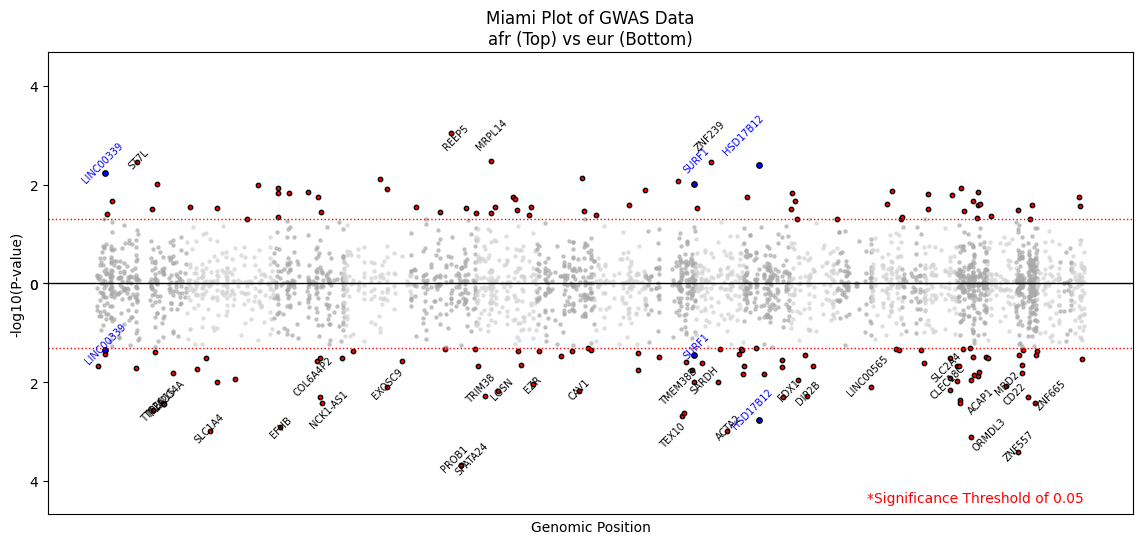

In [19]:
miami('afr')

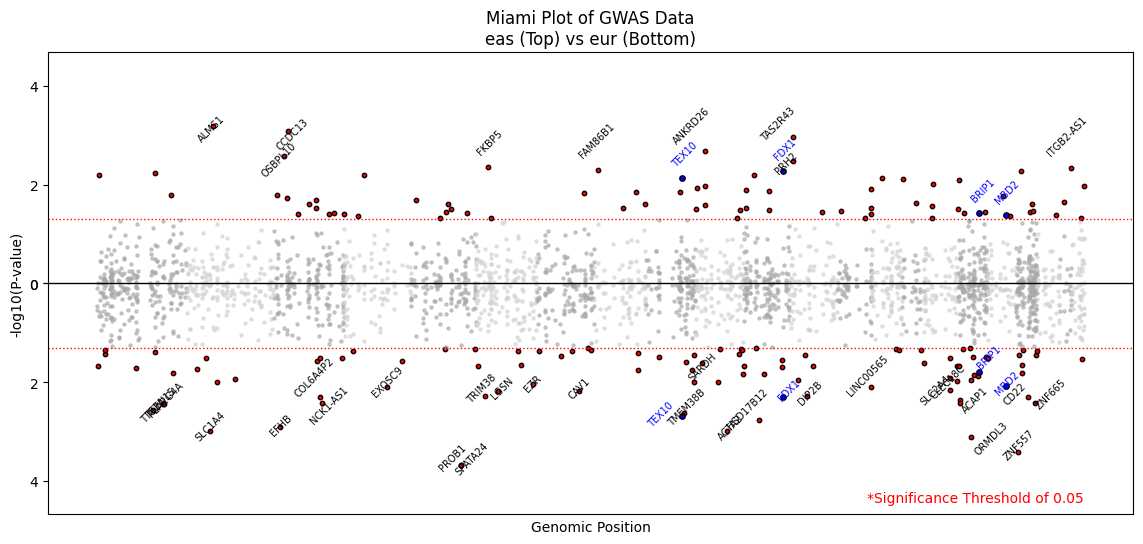

In [20]:
miami('eas')

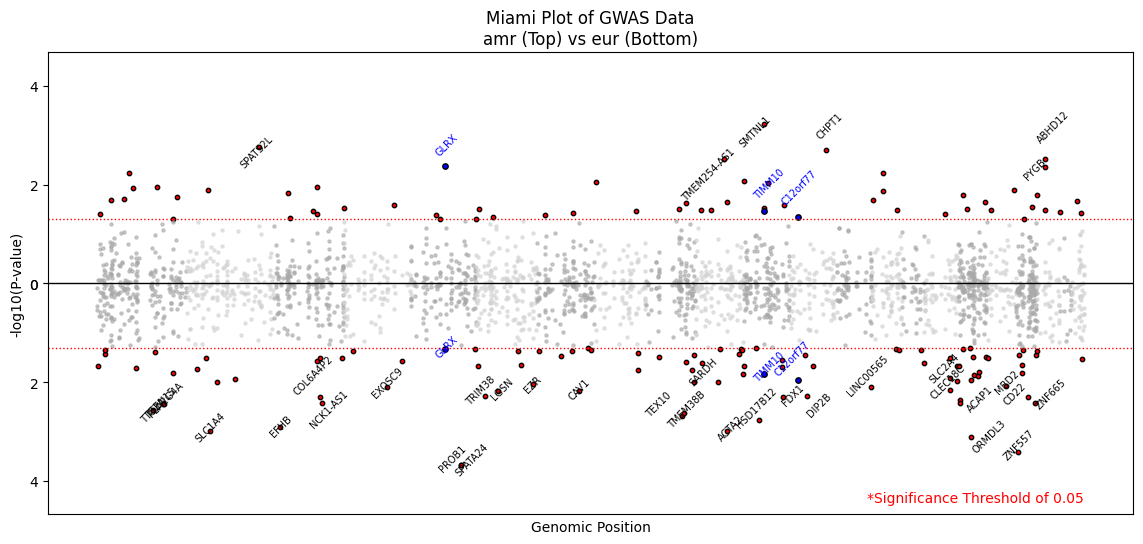

In [21]:
miami('amr')

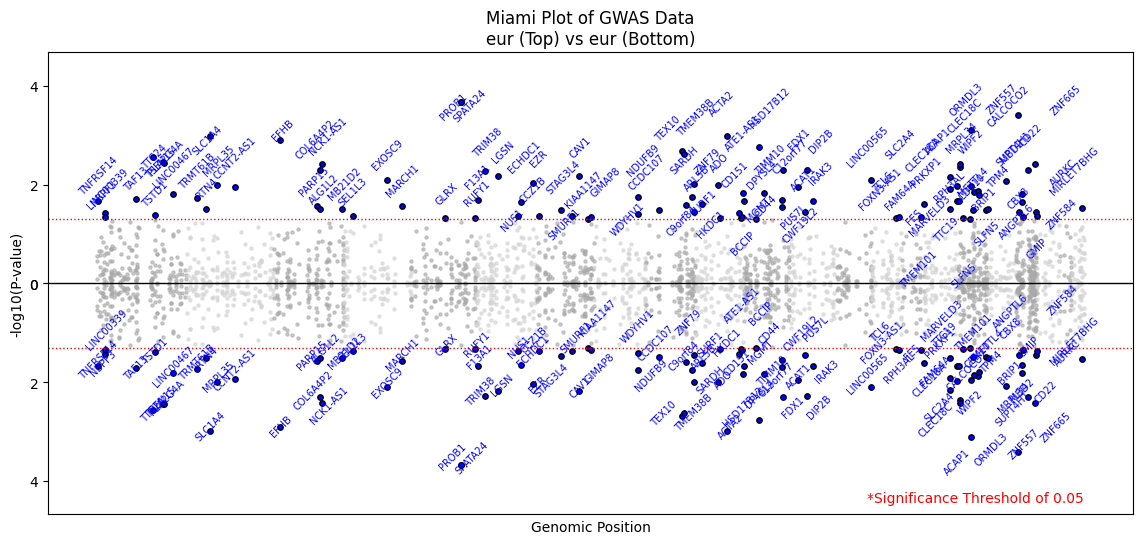

In [22]:
miami('eur')

In [58]:
def miami_loci(pop):
    """Generates a Miami plot for chromosomes 1-22 comparing given population vs 'eur'."""
    
    # Get GWAS data for both populations across all chromosomes
    df1 = data_prep('eur')
    df2 = data_prep(pop)

    # Set up the plot
    plt.figure(figsize=(14, 6))
    sig_color = 'red'  # Color for significant SNPs
    grey_colors = ['lightgrey', 'darkgrey']  # Alternating grey for non-significant SNPs

    # Track chromosome positions for spacing
    chrom_offsets = {}
    cumulative_pos = 0

    for chrom in range(1, 23):
        chr_data1 = df1[df1['CHR'] == chrom]
        chr_data2 = df2[df2['CHR'] == chrom]

        if not chr_data1.empty and not chr_data2.empty:
            min_pos = min(chr_data1['P0'].min(), chr_data2['P0'].min())
            max_pos = max(chr_data1['P0'].max(), chr_data2['P0'].max())

            chr_data1 = chr_data1.copy()
            chr_data2 = chr_data2.copy()

            chr_data1.loc[:, 'plot_pos'] = chr_data1['P0'] - min_pos + cumulative_pos
            chr_data2.loc[:, 'plot_pos'] = chr_data2['P0'] - min_pos + cumulative_pos

            chrom_offsets[chrom] = cumulative_pos + (max_pos - min_pos) / 2
            cumulative_pos += max_pos - min_pos + 1e6  # Add buffer between chromosomes

            # Identify significant SNPs
            significant1 = chr_data1['-log10(P)'] >= -np.log10(1e-3)
            significant2 = chr_data2['-log10(P)'] >= -np.log10(1e-3)
            significant_annotate1 = chr_data1['-log10(P)'] >= -np.log10(1e-3)
            significant_annotate2 = chr_data2['-log10(P)'] >= -np.log10(1e-3)

            # Plot eur SNPs (bottom)
            plt.scatter(chr_data1['plot_pos'][significant1], -chr_data1['-log10(P)'][significant1],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data1['plot_pos'][~significant1], -chr_data1['-log10(P)'][~significant1],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)
            
            # Plot pop SNPs (top)
            plt.scatter(chr_data2['plot_pos'][significant2], chr_data2['-log10(P)'][significant2],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data2['plot_pos'][~significant2], chr_data2['-log10(P)'][~significant2],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)

            # Store all text annotations
            texts = []

            # Annotate significant SNPs with 'ID' (top)
            for i, row in chr_data2[significant_annotate2].iterrows():
                texts.append(plt.text(row['plot_pos'], row['-log10(P)'] + 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Annotate significant SNPs with 'ID' (bottom)
            for i, row in chr_data1[significant_annotate1].iterrows():
                texts.append(plt.text(row['plot_pos'], -row['-log10(P)'] - 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Adjust text positions to avoid overlap
            adjust_text(texts, 
            expand_text=(1.2, 1.5),  
            expand_points=(1.2, 1.5),  
            force_text=(0.3, 0.5),  
            force_points=(0.3, 0.5),  
            lim=200)  

    # Remove chromosome number blocks
    plt.xticks([])  

    # Adjust y-axis: Keep values negative but display them as positive
    max_y = max(df1['-log10(P)'].max(), df2['-log10(P)'].max()) + 1
    y_ticks = np.arange(0, np.ceil(max_y), 2)
    plt.yticks(list(-y_ticks) + list(y_ticks), labels=[str(int(abs(y))) for y in list(-y_ticks) + list(y_ticks)])
    plt.ylim(-max_y, max_y)  

    # Add genome-wide significance and 1e-3 threshold lines
    plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    plt.axhline(y=-np.log10(1e-3), color='red', linestyle='dotted', linewidth=1)
    plt.axhline(y=np.log10(1e-3), color='red', linestyle='dotted', linewidth=1)

    # Add annotation for significance threshold
    plt.text(cumulative_pos * 1, -max_y + 0.25, "*Significance Threshold of 0.001", 
         color='red', fontsize=10, ha='right')

    # Labels and title
    plt.xlabel("Genomic Position")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Miami Plot of GWAS Data\n{pop} (Top) vs eur (Bottom)")

    # Optionally save the plot
    #plt.savefig(f'../plots/miami/{pop}.png', dpi=300)

    # Show the plot
    plt.show()

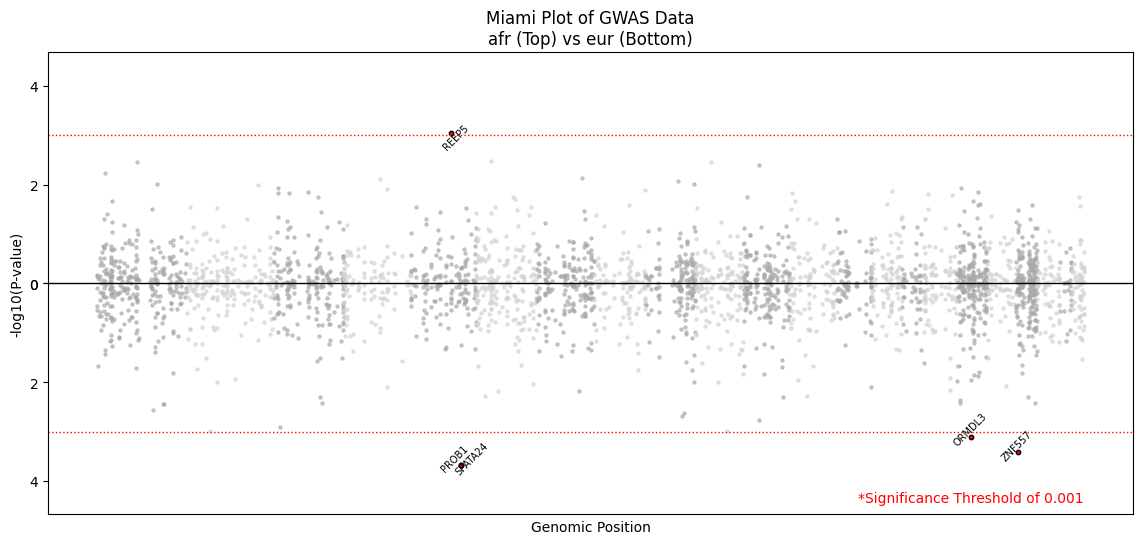

In [59]:
miami_loci('afr')

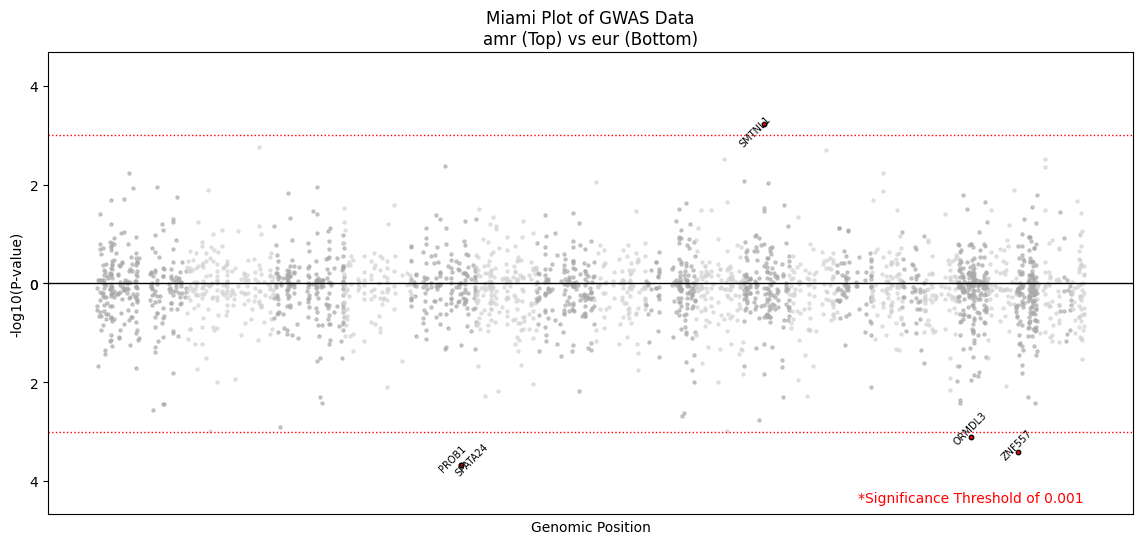

In [60]:
miami_loci('amr')

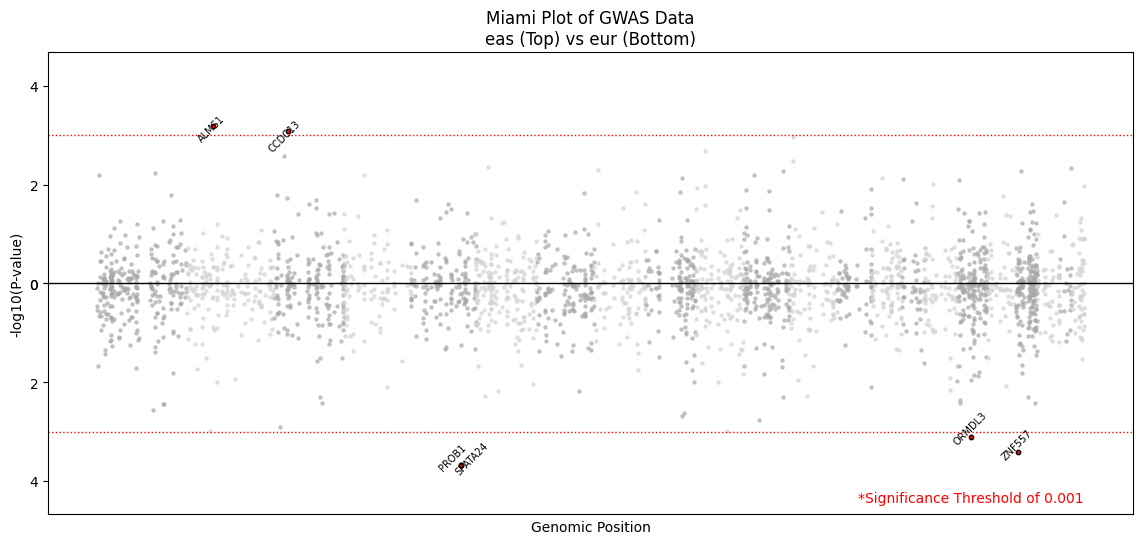

In [61]:
miami_loci('eas')

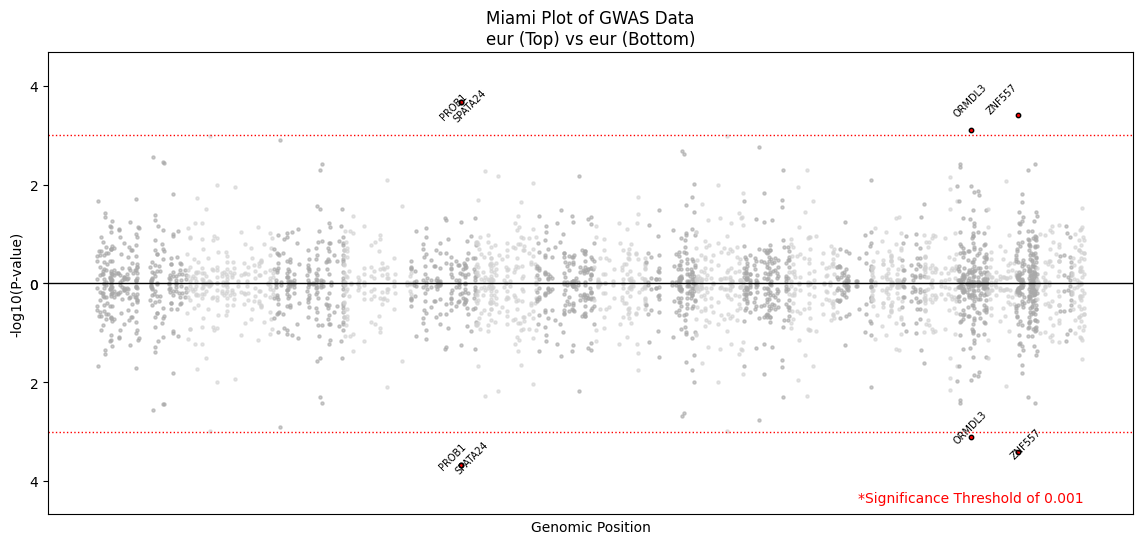

In [62]:
miami_loci('eur')

In [ ]:
def data_prep(chrom_num, pop):
    # Read the GWAS summary statistics file

    file_path = f'../data/assoc/{chrom_num}.{pop}.assoc.dat'

    df = pd.read_csv(file_path, sep="\t")

    df = df.drop(columns=['PANEL', 'FILE'])

    df = df.set_index('ID')

    # Select relevant columns
    df = df[['CHR', 'P0', 'TWAS.P']].dropna()  # Drop missing values

    # Strip whitespace and convert to numeric, forcing errors to NaN
    df['TWAS.P'] = pd.to_numeric(df['TWAS.P'].str.strip(), errors='coerce')

    # Drop NaN values
    df = df.dropna()

    # Convert P-values to -log10(P) for plotting
    # df['-log10(P)'] = -np.log10(df['TWAS.P'])
    df['TWAS.P'] = df['TWAS.P'].astype(float)
    df['-log10(P)'] = df['TWAS.P'].apply(lambda x: -np.log10(x))    

    # Convert chromosome numbers to integers for sorting
    df['CHR'] = df['CHR'].astype(int)

    # Sort by chromosome and position
    df = df.sort_values(by=['CHR'])

    return df

In [ ]:
def miami(chrom_num, pop):

    df1 = data_prep(chrom_num, pop)
    df2 = data_prep(chrom_num, 'eur')

    print(f"Data for {pop}:")
    print(df1.describe())
    print(f"Data for eur:")
    print(df2.describe())

    # Set up the plot
    plt.figure(figsize=(12, 6))
    colors = ['blue', 'red']  # Alternating colors for chromosomes

    # Plot each chromosome separately
    for i, chrom in enumerate(df1['CHR'].unique()):
        chr_data = df1[df1['CHR'] == chrom]
        plt.scatter(chr_data['P0'], chr_data['-log10(P)'], 
                    color=colors[i % 2], label=f'{pop}', s=5)
        
    # Plot each chromosome separately
    for i, chrom in enumerate(df2['CHR'].unique()):
        chr_data = df2[df2['CHR'] == chrom]
        plt.scatter(chr_data['P0'], -chr_data['-log10(P)'], 
                    color=colors[1], label=f'eur', s=5)

    # Add significance threshold line (suggested genome-wide threshold: 5e-8)
    plt.axhline(y=-np.log10(5e-8), color='black', linestyle='dashed', linewidth=1)
    plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1)
    plt.axhline(y=np.log10(5e-8), color='black', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("x")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Miami Plot of GWAS Data (Population: {pop} vs eur, Chromosome: {chrom_num})")
    plt.legend(loc="upper right", markerscale=3, fontsize=8)

    # Show the plot
    plt.show()

    # os.makedirs(f'../plots/manhattan/{pop}', exist_ok=True)
    # plt.savefig(f'../plots/manhattan/{pop}/chr{chrom_num}.png')





In [28]:
import tarfile

tar_path = "../data/gene_expressions/chr_5.tar.gz"
pd.read_csv("../data/gene_associations/chr5.afr.assoc.dat", sep="\t")


,PANEL,FILE,ID,CHR,P0,P1,HSQ,BEST.GWAS.ID,BEST.GWAS.Z,EQTL.ID,EQTL.R2,EQTL.Z,EQTL.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P
0,NaN,/Users/yiting/Desktop/cap3/out/compute_weights...,MAST4,5,66596347,67169595,0.0814,rs42325,-3.164,rs7700366,-0.002115,4.07,0.38733,71,4,lasso,-0.0013,4.600000e-01,0.3420,0.732388
1,NaN,/Users/yiting/Desktop/cap3/out/compute_weights...,LINC00847,5,180830956,180835726,0.1446,rs2546425,-2.141,rs34362037,0.052626,4.68,-1.51359,70,1,top1,0.0530,1.100000e-05,-1.5136,0.130131
2,NaN,/Users/yiting/Desktop/cap3/out/compute_weights...,TMEM232,5,110289232,110738956,0.0769,rs2431650,2.437,rs244412,0.051436,5.01,-1.05760,32,1,top1,0.0510,1.400000e-05,-1.0576,0.290237
3,NaN,/Users/yiting/Desktop/cap3/out/compute_weights...,CDKN2AIPNL,5,134402086,134411898,0.0627,NaN,NA,NaN,NA,NA,NA,39,0,enet,0.0450,4.400000e-05,NA,NA
4,NaN,/Users/yiting/Desktop/cap3/out/compute_weights...,LPCAT1,5,1456479,1523977,0.1145,rs13162116,-2.706,rs36986,0.086149,-5.60,1.11135,93,1,top1,0.0860,1.900000e-08,-1.1114,0.266418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,NaN,/Users/yiting/Desktop/cap3/out/compute_weights...,GRAMD3,5,126360131,126496494,0.0948,rs10071667,2.355,rs17528045,-0.002528,3.74,0.61622,67,3,lasso,0.0110,2.900000e-02,0.4172,0.676507
80,NaN,/Users/yiting/Desktop/cap3/out/compute_weights...,REEP5,5,112876386,112922539,0.1362,rs6892724,2.839,rs17135222,0.030542,4.81,-1.66260,41,21,enet,0.0350,3.100000e-04,-3.3145,0.000918
81,NaN,/Users/yiting/Desktop/cap3/out/compute_weights...,ADAM19,5,157398160,157575775,0.1605,rs17599222,2.293,rs1422794,0.118126,6.73,-0.98606,54,1,top1,0.1200,3.900000e-11,-0.9861,0.324105
82,NaN,/Users/yiting/Desktop/cap3/out/compute_weights...,TTC33,5,40714474,40755975,0.0731,rs6874550,2.464,rs6868112,0.021178,-3.76,-1.31429,29,1,top1,0.0210,4.000000e-03,1.3143,0.188750


In [55]:
import pandas as pd

# Function to extract significant genes (TWAS.P ≤ threshold) for one population
def gene_005(pop, thres=0.05):
    file_path = f"../data/gene_associations/chr5.{pop}.assoc.dat"
    
    # Load data
    init_df = pd.read_csv(file_path, sep="\t")
    
    # Drop unnecessary columns
    init_df = init_df.drop(columns=['PANEL', 'FILE'], errors='ignore')
    
    # Set gene ID as index
    init_df = init_df.set_index('ID')
    
    # Ensure 'TWAS.P' is numeric and drop NaNs
    init_df = init_df.dropna(subset=["TWAS.P"])
    init_df['TWAS.P'] = pd.to_numeric(init_df['TWAS.P'].str.strip(), errors='coerce')
    
    # Filter by P-value threshold
    init_df = init_df[init_df['TWAS.P'] <= thres]

    return init_df

# Function to create a binary presence column for a single population
def get_gene_presence(df, pop_name):
    return pd.DataFrame({pop_name: 1}, index=df.index)

# Function to generate a combined binary matrix for multiple populations (rows = populations, columns = genes)
def gene_binary_df(pops, thres=0.05):
    binary_dfs = []  # List to store binary presence DataFrames
    
    for pop in pops:
        df = gene_005(pop, thres)  # Get filtered genes for this population
        binary_df = get_gene_presence(df, pop)  # Convert to presence matrix
        binary_dfs.append(binary_df)  # Append to list

    # Merge all population DataFrames into a single binary presence matrix
    binary_matrix = pd.concat(binary_dfs, axis=1).fillna(0).astype(int)  

    # Transpose so that rows = populations and columns = genes
    # binary_matrix = binary_matrix.T

    return binary_matrix


In [56]:
# Define populations
populations = ["afr", "amr", "eas", "eur"]  # African, American, East Asian, European

# Generate binary presence matrix
binary_matrix = gene_binary_df(populations, thres=0.05)

# Display the first few rows
print(binary_matrix)


            afr  amr  eas  eur
ID                            
TRIO          1    0    0    0
THBS4         1    0    1    0
GALNT10       1    0    0    0
REEP5         1    0    0    0
GLRX          0    1    0    1
MRPS36        0    1    0    0
ATP6AP1L      0    1    0    0
TRIM52-AS1    0    1    0    0
TMEM232       0    0    1    0
ERAP2         0    0    1    0
NUDT12        0    0    1    0
ANKH          0    0    1    0
ADAM19        0    0    1    0
PROB1         0    0    0    1
SPATA24       0    0    0    1
RUFY1         0    0    0    1


/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o

<Figure size 1400x700 with 0 Axes>

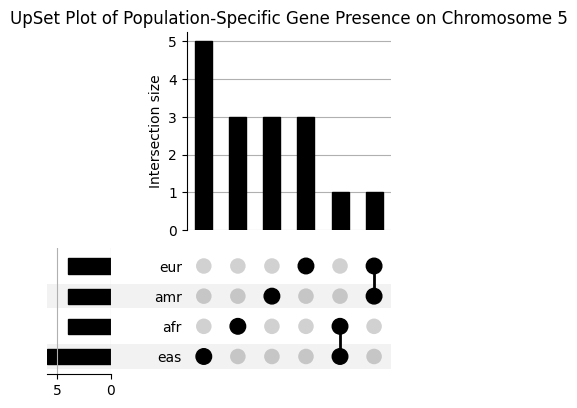

In [60]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

# Convert 0/1 to True/False for UpSet compatibility
binary_matrix = binary_matrix.astype(bool)

# Ensure index is population names
binary_matrix.index.name = "Population"
binary_matrix.columns.name = "ID"

from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

# Convert binary matrix to UpSet format
upset_data = from_indicators(binary_matrix.columns, binary_matrix)

# Create the UpSet plot
plt.figure(figsize=(14, 7))
upset = UpSet(upset_data, sort_by="cardinality")
upset.plot()

# Add title
plt.title("UpSet Plot of Population-Specific Gene Presence on Chromosome 5")

plt.show()





/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o

<Figure size 1600x800 with 0 Axes>

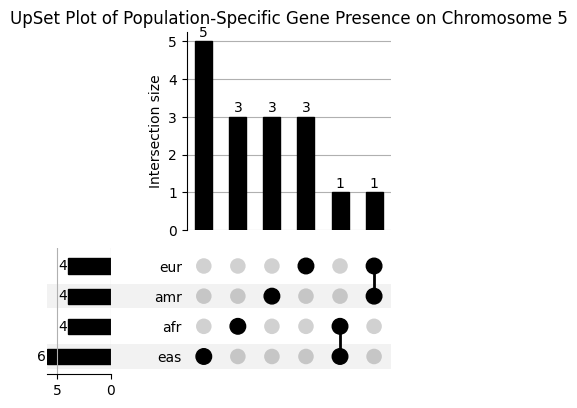

In [61]:
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

# Convert binary matrix to UpSet format
upset_data = from_indicators(binary_matrix.columns, binary_matrix)

# Create the UpSet plot
plt.figure(figsize=(16, 8))  # Increase size for visibility
upset = UpSet(upset_data, sort_by="cardinality", show_counts=True)
upset.plot()

# Rotate x-axis labels (genes) for better visibility
plt.xticks(rotation=90)

# Add title
plt.title("UpSet Plot of Population-Specific Gene Presence on Chromosome 5")

plt.show()
